In [43]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt 
import seaborn as sea
from collections import Counter
from wordcloud import WordCloud
from scipy import stats
import operator

In [44]:
from codecs import open
from __future__ import division
def read_documents(doc_file):
    docs = []
    labels = []
    with open(doc_file, encoding='utf-8') as f:
        for line in f:
            words = line.strip().split()
            docs.append(words[3:])
            labels.append(words[1])
    return docs, labels

In [45]:
all_docs, all_labels = read_documents('converted_all_sentiment_shuffled.txt')

In [46]:
data = pd.DataFrame({'doc':all_docs,'label':all_labels})
data.head()

,doc,label
0,"[i, bought, this, album, because, i, loved, th...",neg
1,"[i, was, misled, and, thought, i, was, buying,...",neg
2,"[i, have, introduced, many, of, my, ell, ,, hi...",neg
3,"[anything, you, purchase, in, the, left, behin...",pos
4,"[i, loved, these, movies, ,, and, i, cant, wia...",pos


<AxesSubplot:>

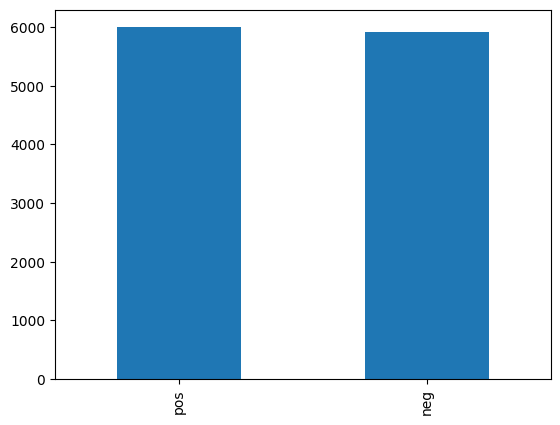

In [47]:
data['label'].value_counts().plot.bar()

In [48]:
data.shape

(11914, 2)

In [49]:
data.isnull().sum()

doc      0
label    0
dtype: int64

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   doc     11914 non-null  object
 1   label   11914 non-null  object
dtypes: object(2)
memory usage: 186.3+ KB


In [51]:
def ToText(docs):
  text =[]
  for doc in docs:
    str = ""
    for e in doc:
      string = " "+e
      str += string
    text.append(str)
  return text

In [52]:
data['doc'] = ToText(data['doc'])

In [53]:
def documentsplit(x, y, split_percentage):
      split_point = int((1-split_percentage)*len(all_docs))
      train_docs = all_docs[:split_point]
      train_labels = all_labels[:split_point]  
      eval_docs = all_docs[split_point:]
      eval_labels = all_labels[split_point:]
      return train_docs, train_labels, eval_docs, eval_labels

In [54]:
train_docs, train_labels, test_docs, test_labels = documentsplit(all_docs, all_labels, 0.20)

In [55]:
def train_naviebayes(documents, labels): 
    indexesOfLabels, countOfLabels, percentageOfLabels = ({} for _ in range(3))
    for k in set(labels):       
        indexesOfLabels[k] = np.where(np.array(labels)==k)
        stopWords = ['.',',','"','(',')','the','and','to','is','a','it','this','that','of','i','you','in','for',"'s"]
        countOfLabels[k] = Counter(w for doc in np.array(documents, dtype=object)[indexesOfLabels[k]] for w in doc if w not in stopWords)
        countOfLabels[k]['UNKNOWN'] = 1
        
        totalNumberOfLabels = sum(list(countOfLabels[k].values()))
        percentageOfLabels[k] = len(np.array(documents, dtype=object)[indexesOfLabels[k]]) / len(documents)
    
        for key in countOfLabels[k]:
            countOfLabels[k][key] = np.log((countOfLabels[k][key]+1)/(totalNumberOfLabels+len(countOfLabels[k])))
    return countOfLabels, percentageOfLabels

In [56]:
countOfLabels, percentageOfLabels =  train_naviebayes(train_docs, train_labels)


In [57]:
def logValuesPred(document, label, countOfLabels, percentageOfLabels):
    labels = countOfLabels[label]
    keys = len(labels)
    logarithmicValues = {}
    logarithmicValues[tuple(document)] = 0
    for i in document:
        if labels[i] != 0:
            logarithmicValues[tuple(document)] += labels[i]
        else:
            logarithmicValues[tuple(document)] += countOfLabels[label]['UNKNOWN']
    logarithmicValues[tuple(document)] += np.log(percentageOfLabels[label])  
    return list(logarithmicValues.values())

In [58]:
def classifynavivebayes(document, countOfLabels, initals):
    probabilitiesOfPredictions = {}
    for key in countOfLabels.keys():
        probabilitiesOfPredictions[key] = logValuesPred(document, key, countOfLabels, percentageOfLabels)
    return max(probabilitiesOfPredictions.items(), key=operator.itemgetter(1))[0]

In [59]:
classifynavivebayes(['ravi','is','not','liking','this','course'],countOfLabels,percentageOfLabels)

'neg'

In [60]:
classifynavivebayes(['ravi','did','enjoys','this','course'],countOfLabels,percentageOfLabels)

'pos'

In [61]:
def evaluationnavivebayes(docs, countOfLabels, percentageOfLabels):
    finalPredictions = [classifynavivebayes(doc, countOfLabels,percentageOfLabels) for doc in docs]
    return finalPredictions

In [62]:
model_predictions = evaluationnavivebayes(test_docs, countOfLabels, percentageOfLabels)

In [63]:
def accuracyScore(true_labels, predicted_labels):
    return np.sum(np.array(true_labels) == np.array(predicted_labels)) / len(true_labels)

In [64]:

print("Accuracy of the NaiveBayes Classifier: " + str(round(accuracyScore(test_labels, model_predictions)*100,2)) + " % ")

Accuracy of the NaiveBayes Classifier: 82.04 % 


In [65]:
indexesOfLabels = np.where(np.array(test_labels)!=np.array(model_predictions))

In [66]:
wrongPred = pd.DataFrame(np.column_stack([np.array(test_docs,dtype=object)[indexesOfLabels], np.array(model_predictions)[indexesOfLabels]]), columns=['doc','badLabel'])


In [67]:
wrongPred['positiveLogarithimcProbability'] = pd.Series(logValuesPred(document, 'pos', countOfLabels,percentageOfLabels)[0] for document in wrongPred.iloc[:,0])
wrongPred['negativeLogarithimcProbability'] = pd.Series(logValuesPred(document, 'neg', countOfLabels, percentageOfLabels)[0] for document in wrongPred.iloc[:,0])
wrongPred['absoluteDifference'] = np.abs(wrongPred['positiveLogarithimcProbability']-wrongPred['negativeLogarithimcProbability'])

In [68]:
wrongPred.sort_values('absoluteDifference', ascending=True)


,doc,badLabel,positiveLogarithimcProbability,negativeLogarithimcProbability,absoluteDifference
53,"[i, love, the, firm, workouts, ,, and, i, love...",pos,-1565.408410,-1565.414580,0.006170
123,"[the, pressure, on, the, rain, setting, is, so...",pos,-753.863680,-753.878139,0.014458
102,"[why, are, the, newer, products, getting, slow...",pos,-984.702142,-984.720672,0.018530
308,"[this, cd, is, ,, without, a, doubt, amazing, ...",pos,-777.804985,-777.834094,0.029110
41,"[jet, li, as, a, contrac, killer, ?, come, on,...",pos,-405.946571,-405.981259,0.034688
...,...,...,...,...,...
17,"[the, decalogue, is, one, of, several, excelle...",pos,-6922.689505,-6957.213093,34.523588
219,"[i, installed, norton, antivirus, 2007, immedi...",neg,-2993.978151,-2953.929015,40.049136
141,"[i, grew, up, reading, harold, evan, 's, sunda...",pos,-12189.457923,-12243.023237,53.565314
226,"[i, 've, been, using, norton, antivirus, 2002,...",neg,-4675.799856,-4610.115068,65.684788


In [69]:
def crossValidation(documents,labels,percentageOfLabels, N=5):
    totalCorrectPredictions = 0
    totalPredictions = 0    
    for fold in range(N):     
        fold_start = int(fold * (int(len(documents))/N))
        fold_end = int((fold+1) * (int(len(documents))/N))
        train_docs_fold = documents[:fold_start] + documents[fold_end:]
        train_labels_fold = labels[:fold_start] + labels[fold_end:]
        test_docs_fold = documents[fold_start:fold_end]
        test_labels_fold = labels[fold_start:fold_end]
        countOfLabels, percentageOfLabels = train_naviebayes(train_docs_fold, train_labels_fold)
        modelPredictions = evaluationnavivebayes(test_docs_fold, countOfLabels, percentageOfLabels)
        modelAccuracy = accuracyScore(test_labels_fold, modelPredictions)  
        toalTestLabels = len(test_labels_fold)
        correctPredictions = np.sum(np.array(test_labels_fold, dtype=object) == np.array(modelPredictions))
        totalCorrectPredictions += correctPredictions
        totalPredictions += toalTestLabels
        
    intervalEstimate = stats.beta(totalCorrectPredictions + 1, totalPredictions-totalCorrectPredictions + 1)
    lowerEnd, higherEnd = intervalEstimate.interval(0.95)
    
    return totalCorrectPredictions, totalPredictions, totalCorrectPredictions/totalPredictions, [lowerEnd,higherEnd]

In [70]:
totalCorrectPreds, totalPreds, NewAccuracyScore, intervalEstimate = crossValidation(all_docs, all_labels,percentageOfLabels)

In [71]:
print("New Accuracy of the NaiveBayes Classifier with 5-Fold Validation: " + str(round(NewAccuracyScore*100,2)) + " % ")
print("New Interval Estimate of the NaiveBayes Classifier with 5-Fold Validation: " + str(intervalEstimate))

New Accuracy of the NaiveBayes Classifier with 5-Fold Validation: 81.38 % 
New Interval Estimate of the NaiveBayes Classifier with 5-Fold Validation: [0.80674090296086, 0.820718917699347]


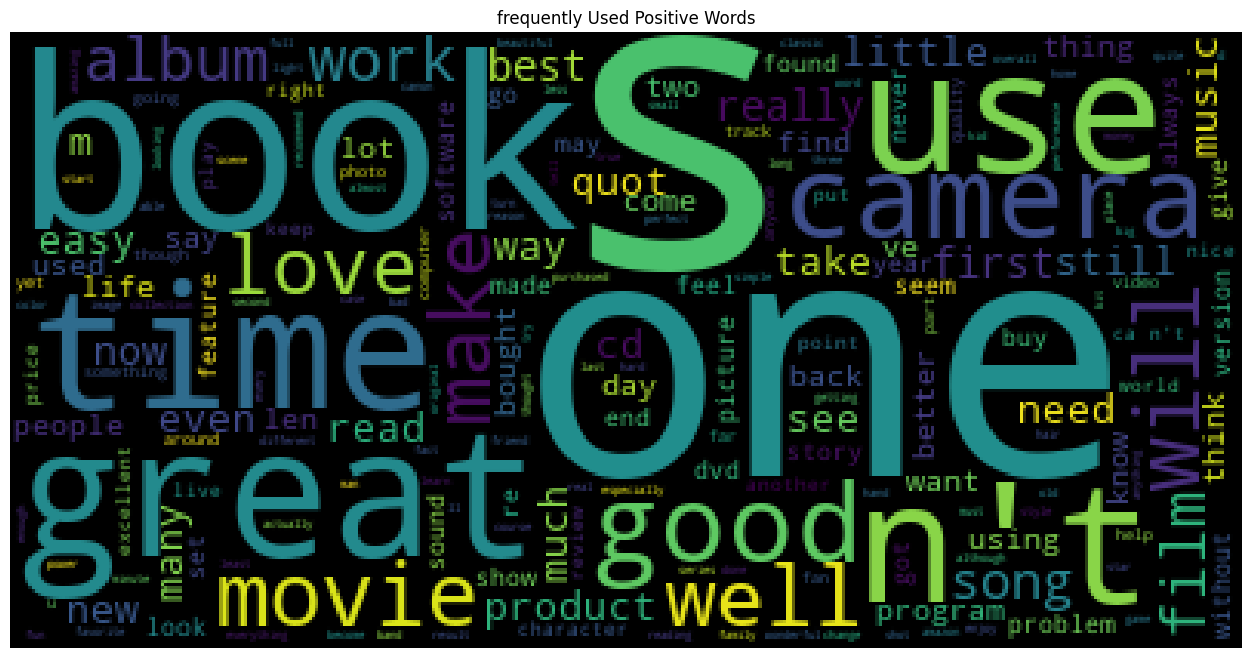

In [72]:
posW =' '.join([text for text in data['doc'][data['label'] == 'pos']])
wordcloud = WordCloud().generate(posW)
plt.figure(figsize=(20, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("frequently Used Positive Words")
plt.show()

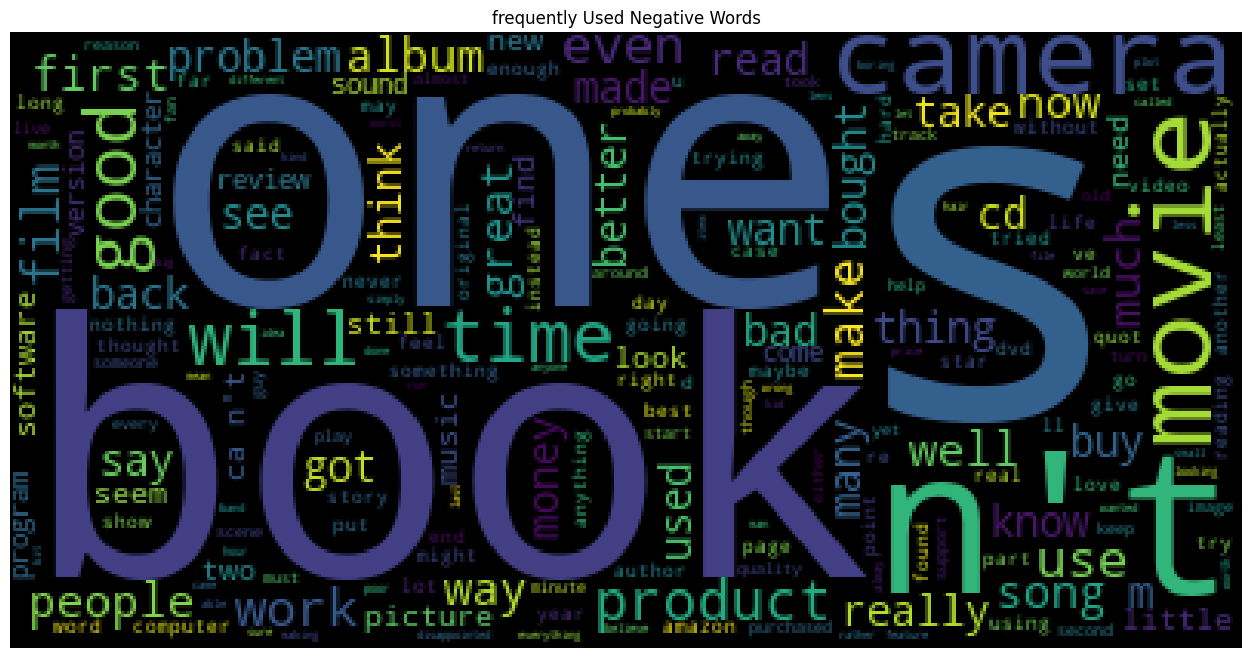

In [74]:
negW =' '.join([text for text in data['doc'][data['label'] == 'neg']])
wordcloud = WordCloud().generate(negW)
plt.figure(figsize=(20, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("frequently Used Negative Words")
plt.show()